# <center>JobChangeClassifier</center>
<img src="https://www.personalcareermanagement.com/wp-content/uploads/2014/02/change-300x213.jpg" width="300" height="200" align="center"/>

# Task Details
This dataset is designed to understand the factors that lead to a person to work for a different company(leaving current job), by model(s) that uses the current credentials/demographics/experience to predict the probability of a candidate to look for a new job or will work for the company.

The whole data divided to train and test. Sample submission has been provided correspond to enrollee_ id of test set (enrolle_ id | target)

## Notes 

The dataset is imbalanced.

Most features are categorical (Nominal, Ordinal, Binary), some with high cardinality.

Missing imputation can be a part of your pipeline as well.

## Features

**enrollee_id** : Unique ID for candidate

**city**: City code

**city_development_index** : Developement index of the city (scaled)

**gender**: Gender of candidate

**relevent_experience**: Relevant experience of candidate

**enrolled_university**: Type of University course enrolled if any

**education_level**: Education level of candidate

**major_discipline** :Education major discipline of candidate

**experience**: Candidate total experience in years

**company_size**: No of employees in current employer's company

**company_type** : Type of current employer

**lastnewjob**: Difference in years between previous job and current job

**training_hours**: training hours completed

**target**: 0 – Not looking for job change, 1 – Looking for a job change

# Importing Libraries

In [1]:
#%% Imports
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap
%matplotlib inline

from pprint import pprint
from IPython.display import display 
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, roc_auc_score

# Read in Training Data (aug_train.csv)

## Initial Glance at Training Data

In [2]:
#%% Read aug_train.csv
aug_train = pd.read_csv('../input/hr-analytics-job-change-of-data-scientists/aug_train.csv')
#%% Initial Glance at Data
display(aug_train.info(verbose = True,null_counts=True))
print(aug_train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

None

(19158, 14)


aug_train has 1**9,158 observations** with **13 features** and **1 target variable**. The dataset has **missing data** and must be handled properly. 

# Data Visualization

## enrollee_id 
enrolle_id is an meaningless feature that is a unique value for each employee. 

In [3]:
#%% count total number of unique values in enrollee_id column
print('Number of Unique Values: ' + str(aug_train['enrollee_id'].nunique()))

Number of Unique Values: 19158


## city
city has 123 unique values and is a categorical variable. 

In [4]:
print('Number of Unique Values: ' + str(aug_train['city'].nunique()))
print('Number of NaN Values: ' + str(sum(aug_train['city'].isnull())))
# top 10 cities 
print((aug_train['city'].value_counts()[0:10]))

Number of Unique Values: 123
Number of NaN Values: 0
city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
city_136     586
city_67      431
city_75      305
city_102     304
city_104     301
Name: city, dtype: int64


## city_development_index
Continous Variable  
[How to Calculate the CDI](https://en.wikipedia.org/wiki/City_development_index#:~:text=The%20City%20Development%20Index%20was,level%20of%20development%20in%20cities.&text=It%20was%20invented%20by%20Dr,analysis%20of%20city%20indicators%20data.)

| Index | Formula   |
|------|------|
|   Infrastructure  | 25 x Water connections + 25 x Sewerage + 25 x Electricity + 25 x Telephone|
|   Waste  | Wastewater treated x 50 + Formal solid waste disposal x 50|
|   Health  | (Life expectancy - 25) x 50/60 + (32 - Child mortality) x 50/31.92|
|   Education  | Literacy x 25 + Combined enrolment x 25 |
|Product	|(log City Product - 4.61) x 100/5.99|
|   City Development  | (Infrastructure index + Waste index + Education index + Health index + City Product index)/5|

Number of Missing Values:  0


count    19158.000000
mean         0.828848
std          0.123362
min          0.448000
25%          0.740000
50%          0.903000
75%          0.920000
max          0.949000
Name: city_development_index, dtype: float64

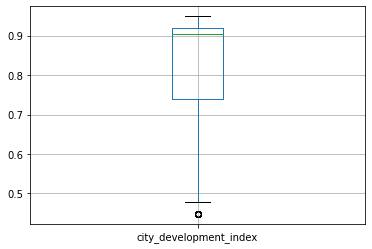

In [5]:
print("Number of Missing Values: ", aug_train['city_development_index'].isna().sum())
display(aug_train['city_development_index'].describe())
boxplot = aug_train.boxplot(column ='city_development_index')

## gender
Catagorical Variable: Male, Female, Other, or NaN

In [6]:
print("Number of Missing Values: ", aug_train['gender'].isna().sum())
fig = px.pie(aug_train['gender'].value_counts(), values='gender', names = aug_train['gender'].value_counts().index,title = 'gender',template='ggplot2')
fig.show()

Number of Missing Values:  4508


## relevent_experience
Binary Variable with no missing values.

In [7]:
print("Number of Missing Values: ", aug_train['relevent_experience'].isna().sum())
fig = px.pie(aug_train['relevent_experience'].value_counts(), values='relevent_experience', 
             names = aug_train['relevent_experience'].value_counts().index,title = 'relevent_experience',template='ggplot2')
fig.show()

Number of Missing Values:  0


## education_level
Catagorical Variable indicating education level of worker, has 460 missing values

In [8]:
print("Number of Missing Values: ", aug_train['education_level'].isna().sum())
fig = px.pie(aug_train['education_level'].value_counts(), values='education_level', 
             names = aug_train['education_level'].value_counts().index,title = 'education_level',template='ggplot2')
fig.show()

Number of Missing Values:  460


## major_discipline
Catagorical Variable indicating major discipline of worker, has 2813 missing values

In [9]:
print("Number of Missing Values: ", aug_train['major_discipline'].isna().sum())
fig = px.pie(aug_train['major_discipline'].value_counts(), values='major_discipline', 
             names = aug_train['major_discipline'].value_counts().index,title = 'major_discipline',template='ggplot2')
fig.show()

Number of Missing Values:  2813


## experience
Ordinal Variable, can replace <1 with 0 and >20 with 21 

In [10]:
print("Number of Missing Values: ", aug_train['experience'].isna().sum())
fig = px.pie(aug_train['experience'].value_counts(), values='experience', 
             names = aug_train['experience'].value_counts().index,title = 'experience',template='ggplot2')
fig.show()

Number of Missing Values:  65


## company_size
Ordinal Catagorical variable has 5938 missing variables 

In [11]:
print("Number of Missing Values: ", aug_train['company_size'].isna().sum())
fig = px.pie(aug_train['company_size'].value_counts(), values='company_size', 
             names = aug_train['company_size'].value_counts().index,title = 'company_size',template='ggplot2')
fig.show()

Number of Missing Values:  5938


## company_type
Catagorical Variable 

In [12]:
print("Number of Missing Values: ", aug_train['company_type'].isna().sum())
fig = px.pie(aug_train['company_type'].value_counts(), values='company_type', 
             names = aug_train['company_type'].value_counts().index,title = 'company_type',template='ggplot2')
fig.show()

Number of Missing Values:  6140



## last_new_job
Catagorical Variable 

In [13]:
print("Number of Missing Values: ", aug_train['last_new_job'].isna().sum())
fig = px.pie(aug_train['last_new_job'].value_counts(), values='last_new_job', 
             names = aug_train['last_new_job'].value_counts().index,title = 'last_new_job',template='ggplot2')
fig.show()

Number of Missing Values:  423



## training_hours
Continous variable

Number of Missing Values:  0


count    19158.000000
mean        65.366896
std         60.058462
min          1.000000
25%         23.000000
50%         47.000000
75%         88.000000
max        336.000000
Name: training_hours, dtype: float64

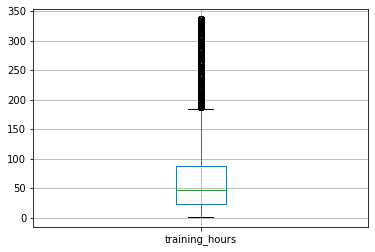

In [14]:
print("Number of Missing Values: ", aug_train['training_hours'].isna().sum())
display(aug_train['training_hours'].describe())
aug_train.boxplot(column ='training_hours')

## target

target is the variable we are trying to predict and calculate the probablities for.   

**0 – Not looking for job change, 1 – Looking for a job change.**

It is better to have a high recall to better target employees who are looking for a job change.  
This is an unbalanced classification problem as seen in the pie chart below.

In [15]:
print("Number of Missing Values: ", aug_train['target'].isna().sum())
fig = px.pie(aug_train['target'].value_counts(), values='target', 
             names = aug_train['target'].value_counts().index,title = 'target',template='ggplot2')
fig.show()

Number of Missing Values:  0


# Read in Testing Data (aug_test.csv)

## Initial Glance at Testing Data

In [16]:
#%% Read aug_test.csv
aug_test = pd.read_csv('../input/hr-analytics-job-change-of-data-scientists/aug_test.csv')
#%% Initial Glance at Data
display(aug_test.info(verbose = True,null_counts=True))
print(aug_test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   object 
 2   city_development_index  2129 non-null   float64
 3   gender                  1621 non-null   object 
 4   relevent_experience     2129 non-null   object 
 5   enrolled_university     2098 non-null   object 
 6   education_level         2077 non-null   object 
 7   major_discipline        1817 non-null   object 
 8   experience              2124 non-null   object 
 9   company_size            1507 non-null   object 
 10  company_type            1495 non-null   object 
 11  last_new_job            2089 non-null   object 
 12  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 216.4+ KB


None

(2129, 13)


# Prepare Data for LightGBM

Extract only the features from aug_train and aug_test and rowbind them. We then will perform label encoding so that the LightGBM can be used.

In [17]:
#%% Prepare Data for LightGBM

# Seperate aug_train into target and features 
y = aug_train['target']
X_aug_train = aug_train.drop('target',axis = 'columns')
# save the index for X_aug_train 
X_aug_train_index = X_aug_train.index.to_list()

# row bind aug_train features with aug_test features 
# this makes it easier to apply label encoding onto the entire dataset 
X_aug_total = X_aug_train.append(aug_test,ignore_index = True)
display(X_aug_total.info(verbose = True,null_counts=True))

# save the index for X_aug_test 
X_aug_test_index = np.setdiff1d(X_aug_total.index.to_list() ,X_aug_train_index) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21287 entries, 0 to 21286
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             21287 non-null  int64  
 1   city                    21287 non-null  object 
 2   city_development_index  21287 non-null  float64
 3   gender                  16271 non-null  object 
 4   relevent_experience     21287 non-null  object 
 5   enrolled_university     20870 non-null  object 
 6   education_level         20775 non-null  object 
 7   major_discipline        18162 non-null  object 
 8   experience              21217 non-null  object 
 9   company_size            14727 non-null  object 
 10  company_type            14513 non-null  object 
 11  last_new_job            20824 non-null  object 
 12  training_hours          21287 non-null  int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 2.1+ MB


None

## MultiColumnLabelEncoder

In [18]:
#%% MultiColumnLabelEncoder
# Code snipet found on Stack Exchange 
# https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
# from sklearn.preprocessing import LabelEncoder

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                # convert float NaN --> string NaN
                output[col] = output[col].fillna('NaN')
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

# store the catagorical features names as a list      
cat_features = X_aug_total.select_dtypes(['object']).columns.to_list()

# use MultiColumnLabelEncoder to apply LabelEncoding on cat_features 
# uses NaN as a value , no imputation will be used for missing data
X_aug_total_transform = MultiColumnLabelEncoder(columns = cat_features).fit_transform(X_aug_total)

In [19]:
#%% Before and After LabelEncoding
display(X_aug_total)
display(X_aug_total_transform)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21282,1289,city_103,0.920,Male,No relevent experience,no_enrollment,Graduate,Humanities,16,NaN,Public Sector,4,15
21283,195,city_136,0.897,Male,Has relevent experience,no_enrollment,Masters,STEM,18,NaN,NaN,2,30
21284,31762,city_100,0.887,Male,No relevent experience,no_enrollment,Primary School,NaN,3,NaN,Pvt Ltd,never,18
21285,7873,city_102,0.804,Male,Has relevent experience,Full time course,High School,NaN,7,100-500,Public Sector,1,84


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,8949,5,0.920,1,0,3,0,6,21,8,3,0,36
1,29725,77,0.776,1,1,3,0,6,6,4,6,4,47
2,11561,64,0.624,2,1,0,0,6,15,8,3,6,83
3,33241,14,0.789,2,1,1,0,1,20,8,6,6,52
4,666,50,0.767,1,0,3,2,6,21,4,1,3,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21282,1289,5,0.920,1,1,3,0,2,7,8,5,3,15
21283,195,30,0.897,1,0,3,2,6,9,8,3,1,30
21284,31762,2,0.887,1,1,3,5,3,13,8,6,6,18
21285,7873,4,0.804,1,0,0,1,3,17,1,5,0,84


## Split X_aug_total_transform 

Split X_aug_total_transform back into X_aug_train_transform and X_aug_test_transform by using the index we saved before.

In [20]:
##% Split X_aug_total_transform 
X_aug_train_transform = X_aug_total_transform.iloc[X_aug_train_index, :]
X_aug_test_transform = X_aug_total_transform.iloc[X_aug_test_index, :].reset_index(drop = True) 

In [21]:
##% Before and After LabelEncoding for aug_train 
display(X_aug_train)
display(X_aug_train_transform)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,8949,5,0.920,1,0,3,0,6,21,8,3,0,36
1,29725,77,0.776,1,1,3,0,6,6,4,6,4,47
2,11561,64,0.624,2,1,0,0,6,15,8,3,6,83
3,33241,14,0.789,2,1,1,0,1,20,8,6,6,52
4,666,50,0.767,1,0,3,2,6,21,4,1,3,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,55,0.878,1,1,3,0,2,5,8,3,0,42
19154,31398,5,0.920,1,0,3,0,6,5,8,3,3,52
19155,24576,5,0.920,1,0,3,0,6,21,4,6,3,44
19156,5756,94,0.802,1,0,3,1,3,20,5,6,1,97


In [22]:
##% Before and After LabelEncoding for aug_test 
display(aug_test)
display(X_aug_test_transform)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,1289,city_103,0.920,Male,No relevent experience,no_enrollment,Graduate,Humanities,16,NaN,Public Sector,4,15
2125,195,city_136,0.897,Male,Has relevent experience,no_enrollment,Masters,STEM,18,NaN,NaN,2,30
2126,31762,city_100,0.887,Male,No relevent experience,no_enrollment,Primary School,NaN,3,NaN,Pvt Ltd,never,18
2127,7873,city_102,0.804,Male,Has relevent experience,Full time course,High School,NaN,7,100-500,Public Sector,1,84


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,78,0.827,1,0,0,0,6,19,7,3,0,21
1,9858,5,0.920,0,0,3,0,6,15,8,6,0,98
2,31806,64,0.624,1,1,3,1,3,20,8,6,6,15
3,27385,26,0.827,1,0,3,2,6,2,0,6,0,39
4,27724,5,0.920,1,0,3,0,6,21,3,6,4,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,1289,5,0.920,1,1,3,0,2,7,8,5,3,15
2125,195,30,0.897,1,0,3,2,6,9,8,3,1,30
2126,31762,2,0.887,1,1,3,5,3,13,8,6,6,18
2127,7873,4,0.804,1,0,0,1,3,17,1,5,0,84


## Train-Test Stratified Split

In [23]:
#%%  train-test stratified split using a 80-20 split
# drop enrollee_id for aug_train as it is a useless feature 
train_x, valid_x, train_y, valid_y = train_test_split(X_aug_train_transform.drop('enrollee_id',axis = 'columns'), y, test_size=0.2, shuffle=True, stratify=y, random_state=1301)

# Create the LightGBM data containers
# Make sure that cat_features are used
train_data=lgb.Dataset(train_x,label=train_y, categorical_feature = cat_features)
valid_data=lgb.Dataset(valid_x,label=valid_y, categorical_feature = cat_features)

#Select Hyper-Parameters
params = {'objective':'binary',
          'metric' : 'auc',
          'boosting_type' : 'gbdt',
          'colsample_bytree' : 0.9234,
          'num_leaves' : 13,
          'max_depth' : -1,
          'n_estimators' : 200,
          'min_child_samples': 399, 
          'min_child_weight': 0.1,
          'reg_alpha': 2,
          'reg_lambda': 5,
          'subsample': 0.855,
          'verbose' : -1,
          'num_threads' : 4
}

# Run LightGBM on train data

In [24]:
#%% Train model on selected parameters and number of iterations
lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=valid_data,
                 early_stopping_rounds= 30,
                 verbose_eval= 10
                 )

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning:

Found `n_estimators` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 30 rounds
[10]	valid_0's auc: 0.785084
[20]	valid_0's auc: 0.792307
[30]	valid_0's auc: 0.792991
[40]	valid_0's auc: 0.794378
[50]	valid_0's auc: 0.79469
[60]	valid_0's auc: 0.795666
[70]	valid_0's auc: 0.79567
[80]	valid_0's auc: 0.79587
[90]	valid_0's auc: 0.795936
[100]	valid_0's auc: 0.795521
[110]	valid_0's auc: 0.795771
[120]	valid_0's auc: 0.795708
Early stopping, best iteration is:
[94]	valid_0's auc: 0.796271


In [25]:
#%% Overall AUC
y_hat = lgbm.predict(X_aug_train_transform.drop('enrollee_id',axis = 'columns'))
score = roc_auc_score(y, y_hat)
print("Overall AUC: {:.3f}" .format(score))

Overall AUC: 0.845


# ROC Curve for training/validation data

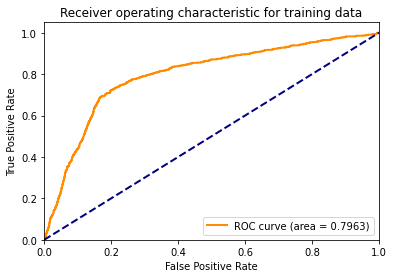

In [26]:
#%% ROC Curve for training/validation data
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
y_probas = lgbm.predict(valid_x) 
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(valid_y, y_probas)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for training data')
plt.legend(loc="lower right")
plt.show()

# Feature Importance 


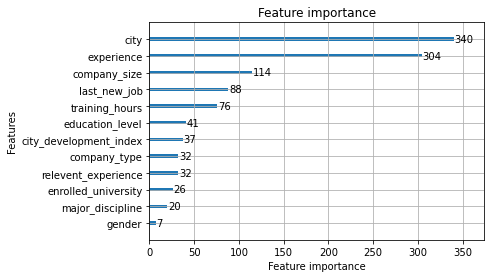

In [27]:
##% Feature Importance 
lgb.plot_importance(lgbm)

/opt/conda/lib/python3.7/site-packages/shap/explainers/_tree.py:300: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



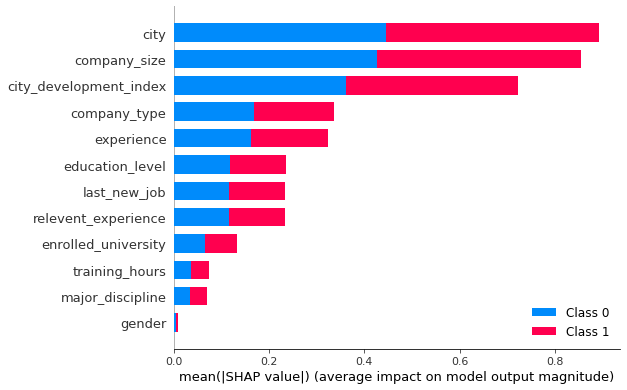

In [28]:
##% Feature Importance using shap package 
lgbm.params['objective'] = 'binary'
shap_values = shap.TreeExplainer(lgbm).shap_values(valid_x)
shap.summary_plot(shap_values, valid_x)

From both feature importance, we can see that **city** contributes a lot if a employee is looking to change jobs or not. The next feature that is also important is **company_size**. The shap package is prefer when finding feature importance as it preservces consistency and accuracy. You can read more about the shap package in the links provided below 

[https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)  
[https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27)

# Predictions for aug_test.csv

In [29]:
#%% Predictions for aug_test.csv
predict = lgbm.predict(X_aug_test_transform.drop('enrollee_id',axis = 'columns')) 
submission = pd.DataFrame({'enrollee_id':X_aug_test_transform['enrollee_id'],'target':predict})
display(submission)

,enrollee_id,target
0,32403,0.224125
1,9858,0.361743
2,31806,0.527523
3,27385,0.066937
4,27724,0.067380
...,...,...
2124,1289,0.532181
2125,195,0.084328
2126,31762,0.061625
2127,7873,0.110820


# Submit Predictions 

In [30]:
##% Submit Predictions 
submission.to_csv('submission.csv',index=False)

# Conclusions / Challenges

**Conclusion**
* LightGBM is a great ML algorithim that handles catagorical features and missing values 
* This is a great dataset to work on and lots of knowledge can be gain from withing with this dataset 
* Researching and reading other Kaggle notebooks is essential for becoming a better data scientist

**Challenges**
* LightGBM has many parameters and other methods that can be utilize to better tune the parameters, this is my first time using LightGBM so mistakes might have occured 
* Working with catagorical features is difficult, especialy when using One-Hot Encoding, this leads to a messy dataframe and longer computational. This is why I opt for Label Encoding and LightGBM 

**Closing Remarks**  
Please comment and like the notebook if it of use to you! Have a wonderful year! 

1-8-2020
Joseph Chan 